# Tracking test
Perform test for the neuron tracking (identities).  
Inputs are RGB and binary detection frames, and the tracker outputs frames similar to the binary segmentation with a different values for each neuron identity. I.e., 0 is background, 1 is for the pixel of the same neuron through time, 2 is for another neuron, etc.

In [2]:
%matplotlib inline

import os, time, sys
from importlib import reload
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
from skimage import io, measure
from scipy.spatial.distance import cdist
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import cluster, mixture, decomposition

# Add parent folder to path in order to access `axoid`
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from axoid.utils.image import to_npint, imread_to_float
from axoid.utils.ccreg import register_stack, shift_image
from axoid.tracking.model import InternalModel
from axoid.tracking.utils import get_rules, rules_violated

%load_ext autoreload
%autoreload 2

interactive(children=(IntSlider(value=0, description='image', max=1065), Output()), _dom_classes=('widget-inte…

Argmin = 102 - argmax = 682


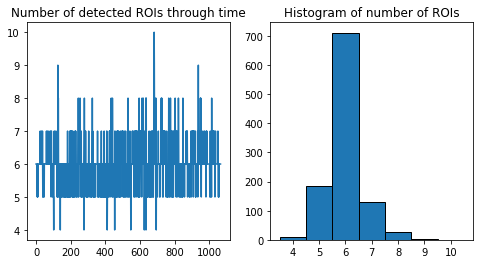

In [78]:
# exp = "/data/talabot/experiments/annotated/SS27485_20190308_tdTomGC6fopt-fl2/SS27485_20190308_tdTomGC6fopt-fl2_004/"
# exp = "/data/talabot/pdm/dataset_cv-annotated/train_fail/A1_S47-3_fly1_S47_tdTom-GC6s_fly3_004/"
exp = "/home/user/talabot/workdir/SS29893/"

rgb_stack = imread_to_float(os.path.join(exp, "RGB.tif"))
seg_stack = io.imread(os.path.join(exp, "seg_ROI.tif")).astype(np.bool)
# seg_stack  = io.imread("/home/user/talabot/workdir/preds.tif").astype(np.bool)
if os.path.isfile(os.path.join(exp, "lbl_ROI.tif")):
    lbl_stack = io.imread(os.path.join(exp, "lbl_ROI.tif"))
else:
    lbl_stack = None

id_cmap = matplotlib.cm.get_cmap('viridis')
id_cmap.set_under([0,0,0])
id_cmap.set_over([1,0,0])
# Display for visualization
reload(plt)
%matplotlib inline
@interact(image = (0, len(rgb_stack) - 1))
def plot_data(image=0):
    labels = measure.label(seg_stack[image], connectivity=1)
    regions = measure.regionprops(labels)
    seg_CoM = np.mean(np.nonzero(labels), 1)
    
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.title("RGB")
    plt.imshow(rgb_stack[image])
    plt.plot(seg_CoM[1], seg_CoM[0], 'wx')
    plt.subplot(132)
    plt.title("Segmentation")
    plt.imshow(seg_stack[image], cmap="gray")
    plt.plot(seg_CoM[1], seg_CoM[0], 'rx')
    if lbl_stack is not None:
        plt.subplot(133)
        plt.title("Labels")
        plt.imshow(lbl_stack[image], cmap=id_cmap, vmin=1)
        plt.plot(seg_CoM[1], seg_CoM[0], 'wx')
    plt.show()

# Plot number of detected ROIs along time
num_roi = np.zeros(len(seg_stack))
for i in range(len(num_roi)):
    num_roi[i] = measure.label(seg_stack[i], connectivity=1, return_num=True)[1]
#     if num_roi[i] == 2:
#         print(i, num_roi[i])

print("Argmin = %d - argmax = %d" % (num_roi.argmin(), num_roi.argmax()))
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(num_roi)
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(num_roi, bins=np.arange(num_roi.min(), num_roi.max() + 2), align='left', edgecolor='k')
plt.xticks(np.arange(num_roi.min(), num_roi.max() + 1))
plt.show()

interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

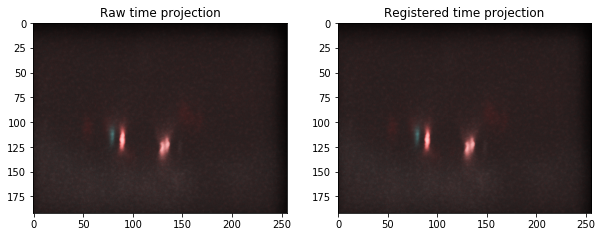

In [69]:
ref_id = 1 # reference frame for registration

# Compute registration through cross-correlation
reg_rgb, reg_rows, reg_cols = register_stack(rgb_stack, ref_num=ref_id, return_shifts=True)
reg_seg = np.zeros_like(seg_stack)
for i in range(len(reg_seg)):
    reg_seg[i] = shift_image(seg_stack[i], reg_rows[i], reg_cols[i])
reg_seg = reg_seg.clip(0, 1)
reg_rgb = reg_rgb.clip(0, 1)
    
# Reference center of mass
ref_CoM = np.mean(np.nonzero(seg_stack[ref_id]), 1)

reload(plt)
%matplotlib inline
@interact(image = (0, len(rgb_stack) - 1))
def plot_data(image=0):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title("Registered input")
    plt.imshow(reg_rgb[image])
    plt.plot(ref_CoM[1], ref_CoM[0], 'wx')
    plt.subplot(122)
    plt.title("Registered binary detection")
    plt.imshow(reg_seg[image], cmap='gray')
    plt.plot(ref_CoM[1], ref_CoM[0], 'rx')
    plt.show()
    
rgb_mean = rgb_stack.mean(0)
rgb_mean /= rgb_mean.max()
reg_rgb_mean = reg_rgb.mean(0)
reg_rgb_mean /= reg_rgb_mean.max()

reload(plt)
%matplotlib inline
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Raw time projection")
plt.imshow(rgb_mean)
plt.subplot(122)
plt.title("Registered time projection")
plt.imshow(reg_rgb_mean)
plt.show()

del rgb_mean, reg_rgb_mean

## Internal model

Updating model took 29 s.
Identity matching took 11 s.


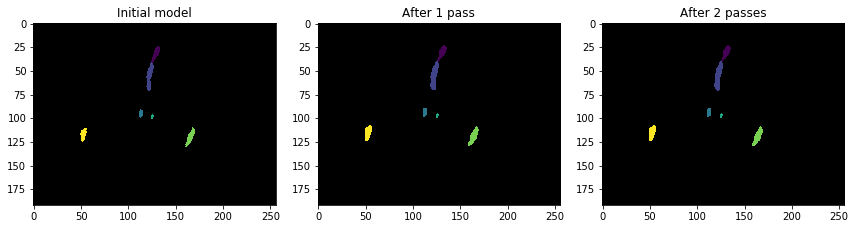

Some axons are overlapping on the model's image!


interactive(children=(IntSlider(value=0, description='image', max=1065), Output()), _dom_classes=('widget-inte…

In [79]:
init_idx = ref_id
n_update = 2

start = time.time()
# Initialization
model = InternalModel()
identities = np.zeros(seg_stack.shape, np.uint8)
rgb_init = imread_to_float(os.path.join(exp, "clust_rgb.png"))
seg_init = imread_to_float(os.path.join(exp, "clust_seg.png"))
# rgb_init = rgb_stack[init_idx]
# seg_init = seg_stack[init_idx]
model.initialize(rgb_init, measure.label(seg_init, connectivity=1))
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title("Initial model")
plt.imshow(model.image, cmap=id_cmap, vmin=0.99)

# Iterate n_update time through the frames to udpate the model
for n in range(n_update):
    for i in range(len(seg_stack)):
        identities[i] = model.match_frame(rgb_stack[i], seg_stack[i], time_idx=i)
        model.update(rgb_stack[i], identities[i], time_idx=i)
    if n == 0:
        plt.subplot(132)
        plt.title("After 1 pass")
        plt.imshow(model.image, cmap=id_cmap, vmin=0.99)
print("Updating model took %d s." % (time.time() - start))

start = time.time()
# Iterate a final time to finalize the identities (without updating the model)
for i in range(len(seg_stack)):
    identities[i] = model.match_frame(rgb_stack[i], seg_stack[i], time_idx=i)
print("Identity matching took %d s." % (time.time() - start))
plt.subplot(133)
plt.title("After %d passes" % n_update)
plt.imshow(model.image, cmap=id_cmap, vmin=0.99)
plt.tight_layout()
plt.show()

if model.overlapping_axons:
    print("Some axons are overlapping on the model's image!")

@interact(image = (0, len(identities) - 1))
def plot_data(image=0):
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(132)
    plt.title("Binary detection")
    plt.imshow(seg_stack[image], cmap='gray')
    plt.subplot(133)
    plt.title("Identities")
    plt.imshow(identities[image], cmap=id_cmap, vmin=0.99, vmax=max([axon.id for axon in model.axons]))
    plt.tight_layout()
    plt.show()

## Error detection

In [72]:
# Display the cost matrix
@interact(n=(0, len(rgb_stack) - 1))
def plot_cost(n=0):
    model.match_frame(rgb_stack[n], seg_stack[n], time_idx=n, debug=True)
    plt.imshow(measure.label(seg_stack[n], connectivity=1), cmap=id_cmap, vmin=1)
    plt.title("ROI labels")
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=0, description='n', max=1066), Output()), _dom_classes=('widget-interact…

57


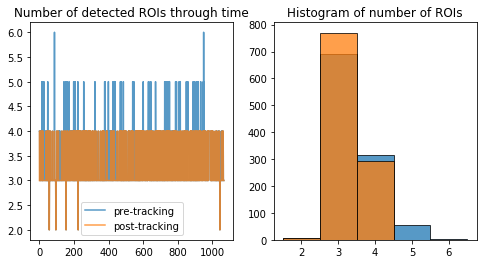

In [73]:
# Plot number of detected ROIs along time
num_roi_id = np.zeros(len(identities))
for i in range(len(num_roi)):
    num_roi_id[i] = measure.label(identities[i].astype(seg_stack.dtype), connectivity=1, return_num=True)[1]
#     if num_roi_id[i] < 4:
#         print(i, num_roi_id[i])
# print(np.sum(num_roi_id < 4))
print(np.argmin(num_roi_id))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(num_roi, alpha=0.75)
plt.plot(num_roi_id, alpha=0.75)
plt.legend(["pre-tracking", "post-tracking"])
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(num_roi, bins=np.arange(num_roi.min(), num_roi.max() + 2), align='left', edgecolor='k', alpha=0.75)
plt.hist(num_roi_id, bins=np.arange(num_roi_id.min(), num_roi_id.max() + 2), align='left', edgecolor='k', alpha=0.75)
plt.xticks(np.arange(num_roi_id.min(), num_roi.max() + 1))
plt.show()

In [75]:
# Look for frames where the row order of axons is violated
# Model row orders <=> rules
rules = get_rules(model.image)
print("Model rules:", rules, sep="\n")

verifs = rules_violated(rules, identities)
print("%d frames against the rules:\n" % np.sum(verifs),
      [i for i in range(len(identities)) if verifs[i]], sep="")

Model rules:
[[1 3]
 [1 4]
 [2 1]
 [2 3]
 [4 3]]
11 frames against the rules:
[309, 321, 323, 416, 421, 570, 652, 662, 687, 817, 873]


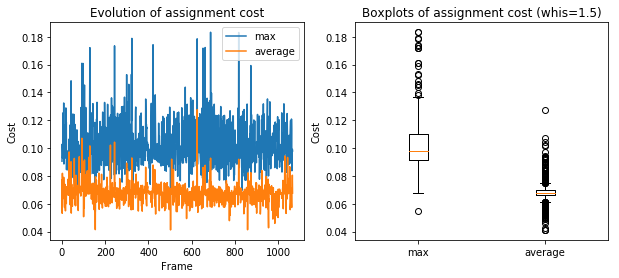

IQR 1.5: 20
[ 42  92  98 104 129 243 299 309 321 323 421 431 570 625 652 662 687 691
 817 873]


In [76]:
# Compute cost of identities for each frame and look for outliers
# Compute first model's features
ids_to_idx = dict()
for i, axon in enumerate(model.axons):
    ids_to_idx.update({axon.id: i})

x_model = np.stack([axon.position for axon in model.axons], axis=0)
x_model -= x_model.mean(0)
area_model = np.array([axon.area for axon in model.axons])
area_model = area_model / area_model.mean()

# Loop over frames
cost_mean = np.zeros(len(identities))
cost_max = np.zeros(len(identities))
for i in range(len(identities)):
    regions = measure.regionprops(identities[i])
    # No ROI --> only dummy axons
    if len(regions) == 0:
        cost_mean[i] = model.TH_DUMMY
        cost_max[i] = model.TH_DUMMY
        continue
    
    # Compute frame features
    x_frame = np.array([region.centroid for region in regions])
    x_frame -= x_frame.mean(0)
    area_frame = np.array([region.area for region in regions])
    area_frame = area_frame / area_frame.mean()
    
    cost_matrix = model.W_AREA * np.abs(area_frame[:, np.newaxis] - area_model[np.newaxis, :])
    if len(regions) > 1 and len(model.axons) > 1:
        cost_matrix += model.match_inner_cost(x_frame, x_model, area_frame, area_model, identities.shape[1])
    
    cost = cost_matrix[np.arange(len(regions)), np.array([ids_to_idx[reg.label] for reg in regions])]
    if cost.size == 0:
        cost_mean[i] = np.nan
        cost_max[i] = np.nan
    else:
        cost_mean[i] = np.mean(cost)
        cost_max[i] = np.max(cost)

iqr_cutoff = 1.5
cost_max_nanfree = cost_max[np.logical_not(np.isnan(cost_max))]
cost_mean_nanfree = cost_mean[np.logical_not(np.isnan(cost_mean))]
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
plt.title("Evolution of assignment cost")
plt.plot(cost_max)
plt.plot(cost_mean)
plt.legend(["max", "average"])
plt.xlabel("Frame")
plt.ylabel("Cost")
plt.subplot(122, sharey=ax1)
plt.title("Boxplots of assignment cost (whis={})".format(iqr_cutoff))
plt.boxplot([cost_max_nanfree, cost_mean_nanfree], whis=iqr_cutoff, labels=["max", "average"])
plt.ylabel("Cost")
plt.show()
q25, q75 = np.percentile(cost_max_nanfree, 25), np.percentile(cost_max_nanfree, 75)
iqr = q75 - q25
outliers = np.where(cost_max_nanfree > (q75 + iqr * iqr_cutoff))[0]
print("IQR {}: {}".format(iqr_cutoff, outliers.size), outliers, sep="\n")

## Fluorescence extraction
Extract tdTomato and GCaMP fluorescence traces for each neurons.  
Careful as small neurons tend to have very stochastic traces.

In [ ]:
n_frames_0 = 10 # number of frames for the R_0 and F_0 computation

# If too many identities, do not compute traces (modify here to force computation)
if identities.max() >= 10:
    print(identities.max(), "different neurons identified, traces are not computed.")
    sys.exit()

# Mean noise intensity in background
bkg_r = np.mean(rgb_stack[np.logical_not(seg_stack),0])
# bkg_g = np.mean(rgb_stack[np.logical_not(seg_stack),1])
    
traces = np.ones((identities.max(), len(identities), 2)) * np.nan
dR_R = np.zeros((identities.max(), len(identities)))
has_tdTom = np.array([True] * identities.max())

start = time.time()
for i in range(len(identities)):
    for j in range(identities.max()):
        roi = rgb_stack[i,...][identities[i] == (j + 1)]
        if roi.size > 0:
            traces[j, i, :] = roi.mean(0)[:2]
print("Computing traces took %.3f s." % (time.time() - start))

for i in range(identities.max()):
    # Check if tdTomato is present in the neuron by comparing the mean trace to bkg noise
    if np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]) >= 1.1 * bkg_r:
        R_t = traces[i,...,1] / traces[i,...,0]
    else: # no tdTomato, compute F instead of R
        R_t = traces[i,...,1]
        has_tdTom[i] = False
        print("Neuron {} has no tdTomato (mean < 1.1 * bkg: {:.3f} < {:.3f}). "
              "Fluorescence computed as dF/F.".format(
            i + 1, np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]), 1.1 * bkg_r))
    R_0 = np.convolve(R_t, np.ones(n_frames_0) / n_frames_0, 'valid')
    R_0 = np.min(np.where(np.isnan(R_0), np.inf, R_0)) # Does not consider np.nan
    # If no window of n_frames_0 exists, search for smaller ones
    for j in range(1, n_frames_0):
        if not np.isinf(R_0):
            break
        R_0 = np.convolve(R_t, np.ones(n_frames_0 - j) / (n_frames_0 - j), 'valid')
        R_0 = np.min(np.where(np.isnan(R_0), np.inf, R_0)) # Does not consider np.nan
    dR_R[i] = (R_t - R_0) / R_0

reload(plt)
%matplotlib inline
N = np.ceil(identities.max() / 4)
plt.figure(figsize=(16, 4*N))
plt.suptitle("Raw traces", fontsize=14)
ymax = 1.1 * np.where(np.isnan(traces) + np.isinf(traces), 0, traces).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d" % (i+1))
    plt.plot(traces[i,...,0], color="C3")
    plt.plot(traces[i,...,1], color="C2")
    plt.xlim(0, len(identities))
    plt.ylim(0, ymax)
    plt.legend(["tdTomato", "GCaMP"])
plt.show()
plt.figure(figsize=(16, 4*N))
plt.suptitle("Processed traces", fontsize=14)
if (has_tdTom == True).any():
    ymin_R = min(0, 1.1 * np.nan_to_num(dR_R[has_tdTom]).min())
    ymax_R = 1.1 * np.where(np.isnan(dR_R[has_tdTom]) + np.isinf(dR_R[has_tdTom]), 0, dR_R[has_tdTom]).max()
if (has_tdTom == False).any():
    ymin_F = min(0, 1.1 * np.nan_to_num(dR_R[np.logical_not(has_tdTom)]).min())
    ymax_F = 1.1 * np.where(np.isnan(dR_R[np.logical_not(has_tdTom)]) + np.isinf(dR_R[np.logical_not(has_tdTom)]),
                            0, dR_R[np.logical_not(has_tdTom)]).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d - " % (i+1) + ("$\Delta$R/R" if has_tdTom[i] else "$\Delta$F/F"))
    plt.plot(dR_R[i], color="C0" if has_tdTom[i] else "C1")
    plt.xlim(0, len(identities))
    plt.ylim(ymin_R if has_tdTom[i] else ymin_F, ymax_R if has_tdTom[i] else ymax_F)
plt.show()

In [ ]:
i = 0
idx = 50
plt.figure()
ymax = 1.1 * np.where(np.isnan(traces) + np.isinf(traces), 0, traces).max()
plt.title("Neuron %d" % (i+1))
plt.plot(traces[i,...,0], color="C3")
plt.plot(traces[i,...,1], color="C2")
plt.xlim(100, 200)
plt.ylim(0, ymax)
plt.legend(["tdTomato", "GCaMP"])
plt.plot(idx, traces[i, idx, 1], 'bx')
plt.show()

# Point set registration & others

In [94]:
# Coherent Point Drift tests
from skimage import morphology as morph
from skimage.color import rgb2gray, gray2rgb
from scipy.ndimage import distance_transform_edt
from axoid.utils.ccreg import compute_shifts, shift_image
from axoid.utils.image import overlay_contours, overlay_mask
from axoid.tracking.pycpd import pycpd as cpd
# import pycpd as cpd

# Model centroids
model_centroids = np.zeros_like(model.image)
for axon in model.axons:
    r, c = axon.position.astype(np.uint16)
    model_centroids[r,c] = axon.id
model_centroids = morph.dilation(model_centroids)

def to_cmap(image, cmap, vmin=None, vmax=None, alpha=None):
    """Change the image to the colormap, and possibly add transparency."""
    if vmin is None:
        vmin = image.min()
    if vmax is None:
        vmax = image.max()
    out = cmap((image.astype(np.float) - vmin) / (vmax - vmin))
    
    if alpha is None:
        return out[..., :-1]
    else:
        out[..., -1] = alpha
        out[image < vmin, -1] = 0
        return out

@interact(i=(0, len(seg_stack) - 1))
def plot(i=682):
# i = 411
    seg_frame = seg_stack[i].copy() #* np.random.choice([0, 1], size=model.image.shape, p=[0.5, 0.5])
    model_image = model.image.copy() #* np.random.choice([0, 1], size=model.image.shape, p=[0.9, 0.1])
    # Sample n pixels from each axons
#     model_image = np.zeros_like(model.image)
#     for axon in model.axons:
#         coords = np.array(np.where(model.image == axon.id), dtype=np.uint16).T
#         coords = coords[np.random.choice(len(coords), size=10, replace=False)]
#         model_image[coords[:, 0], coords[:, 1]] = axon.id
    
    X = np.array(np.where(seg_frame)).T
    Y = np.array(np.where(model_image)).T
#     Y = np.stack([axon.position for axon in model.axons], 0)

    start = time.time()
    rigid_reg = cpd.affine_registration(X=X, Y=Y, sigma2=None, 
                                        max_iterations=200, tolerance=0.001, w=0.01,
                                        only_t=True)
    rigid_reg.register()
    #     row, col = compute_shifts(model.image.astype(np.bool), seg_stack[i])
    #     rigid_reg.TY = Y - np.array([row, col])
    nonrigid_reg = cpd.deformable_registration(X=X, Y=rigid_reg.TY, sigma2=max(rigid_reg.sigma2 * 1, 10), 
                                               max_iterations=200, tolerance=0.001, w=0.01,
                                               alpha=1, beta=10)
    nonrigid_reg.register()
    print("Registrations took %.3f s." % (time.time() - start))
    for string, reg in zip(["Rigid:", "Non-rigid:"], [rigid_reg, nonrigid_reg]):
        print(string)
        print("  sigma2 = {:.3f} - iteration = {}".format(reg.sigma2, reg.iteration))

    # Transform the model
    # Rigid registration
    rigid_model = np.zeros_like(model_image)
    rigid_TY = rigid_reg.TY
    for point, T_point in zip(Y, rigid_TY):
        if 0 <= T_point[0] < rigid_model.shape[0] and 0 <= T_point[1] < rigid_model.shape[1]:
            point = point.astype(np.uint16)
            T_point = T_point.astype(np.uint16)
            rigid_model[T_point[0], T_point[1]] = model_image[point[0], point[1]]
    # Final non-rigid registration
    T_model = np.zeros_like(model_image)
    TY = nonrigid_reg.TY
    for point, T_point in zip(Y, TY):
        if 0 <= T_point[0] < T_model.shape[0] and 0 <= T_point[1] < T_model.shape[1]:
            point = point.astype(np.uint16)
            T_point = T_point.astype(np.uint16)
            T_model[T_point[0], T_point[1]] = model_image[point[0], point[1]]
#     rigid_model = morph.dilation(rigid_model)
#     T_model = morph.dilation(T_model)

    # Make the identity image
    ids = T_model * seg_frame
    for n in range(len(X)):
        # Look best correspondence in model
        idx = nonrigid_reg.P[:, n].argmax()
        # Compute lower bound corresponding to uniform distribution
        c = (2 * np.pi * nonrigid_reg.sigma2) ** (nonrigid_reg.D / 2)
        c = c * nonrigid_reg.w / (1 - nonrigid_reg.w)
        c = c * nonrigid_reg.M / nonrigid_reg.N
        if nonrigid_reg.P[idx, n] > c:
            id = model_image[int(Y[idx, 0]), int(Y[idx, 1])]
            ids[int(X[n, 0]), int(X[n, 1])] = id
    # Watershed to fill gaps in ROIs
    ids = morph.watershed(-distance_transform_edt(seg_frame), markers=ids, mask=seg_frame)
    discarded = np.logical_and(seg_frame, np.logical_not(ids))

    plt.figure(figsize=(12,10))
    plt.subplot(331)
    plt.title("Segmentation")
    plt.imshow(seg_frame, cmap="gray")
    plt.subplot(332)
    plt.title("RGB input")
    plt.imshow(rgb_stack[i], cmap="gray")
    plt.subplot(333)
    plt.title("Identities")
    plt.imshow(overlay_mask(to_cmap(ids, id_cmap, vmin=0.99, vmax=model.image.max()), discarded, 1, [1,0,0]))
    plt.subplot(334)
    plt.title("Model")
    plt.imshow(model_image, cmap=id_cmap, vmin=0.99)
    plt.subplot(335)
    plt.title("Rigid registration")
    plt.imshow(rigid_model, cmap=id_cmap, vmin=0.99)
    plt.subplot(336)
    plt.title("+ non-rigid registration")
    plt.imshow(T_model, cmap=id_cmap, vmin=0.99)
    plt.subplot(337)
    plt.title("Overlay with model")
    plt.imshow(seg_frame, cmap="gray")
    plt.imshow(to_cmap(model_image, id_cmap, vmin=0.99, alpha=0.9))
    plt.subplot(338)
    plt.title("Overlay with rigid registration")
    plt.imshow(seg_frame, cmap="gray")
    plt.imshow(to_cmap(rigid_model, id_cmap, vmin=0.99, alpha=0.75))
    plt.subplot(339)
    plt.title("Overlay with final registration")
    plt.imshow(seg_frame, cmap="gray")
    plt.imshow(to_cmap(T_model, id_cmap, vmin=0.99, alpha=0.75))
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=682, description='i', max=1065), Output()), _dom_classes=('widget-intera…

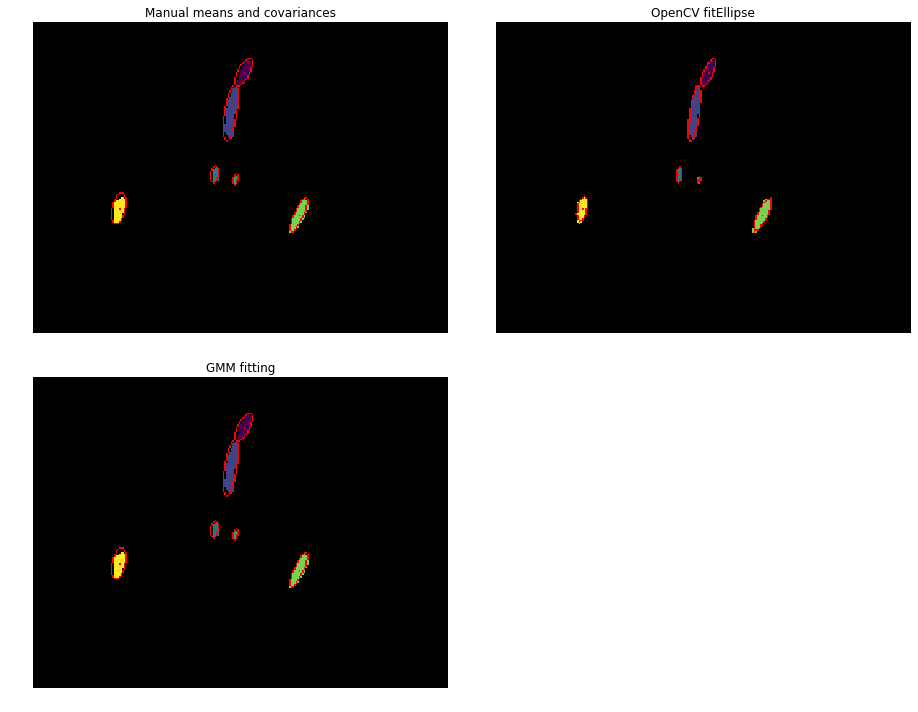

In [170]:
# Ellipse/Gaussian fitting
from skimage.draw import ellipse_perimeter
import cv2
from sklearn.mixture import GaussianMixture

means = np.stack([axon.position for axon in model.axons], axis=0)
covs = np.zeros((len(model.axons), 2, 2))
for n, axon in enumerate(model.axons):
    coords = np.array(np.where(model.image == axon.id)).T.astype(np.float)
    means[n] = coords.mean(0)
    coords -= means[n]
    covs[n] = coords.T @ coords / len(coords)

img1 = to_cmap(model.image, id_cmap, vmin=0.99)
img2 = to_npint(to_cmap(model.image, id_cmap, vmin=0.99))
img3 = to_cmap(model.image, id_cmap, vmin=0.99)
for n, axon in enumerate(model.axons):
    # Use axon mean and covariance
    val, vec = np.linalg.eigh(covs[n])
    angle = np.arctan2(vec[0,1], vec[0,0])
    r, c = np.rint(means[n]).astype(np.uint16)
    rr, cc = ellipse_perimeter(r, c, int(np.sqrt(val[0] * 4) + 0.5), int(np.sqrt(val[1] * 4) + 0.5), 
                               -angle, shape=img1.shape)
    img1[r, c] = np.array([1, 0 ,0])
    img1[rr, cc] = np.array([1, 0 ,0])
    
    # Fit ellipse
    _, contours, _ = cv2.findContours((model.image == axon.id).astype(np.uint8),
                                   cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    ellipse = cv2.fitEllipse(contours[0])
    img2[int(ellipse[0][1] + 0.5), int(ellipse[0][0] + 0.5)] = np.array([255, 0, 0])
    cv2.ellipse(img2, ellipse, (255,0,0))
    
    # Fit gaussian model
    X = np.array(np.where(model.image == axon.id)).T.astype(np.float)
    gmm = GaussianMixture().fit(X)
    mean = gmm.means_[0]
    cov = gmm.covariances_[0]
    
    val, vec = np.linalg.eigh(cov)
    angle = np.arctan2(vec[0,1], vec[0,0])
    r, c = np.rint(mean).astype(np.uint16)
    rr, cc = ellipse_perimeter(r, c, int(np.sqrt(val[0] * 4) + 0.5), int(np.sqrt(val[1] * 4) + 0.5), 
                               -angle, shape=img3.shape)
    img3[r, c] = np.array([1, 0 ,0])
    img3[rr, cc] = np.array([1, 0 ,0])

plt.figure(figsize=(13,10))
plt.subplot(221)
plt.title("Manual means and covariances")
plt.imshow(img1)
plt.axis('off')
plt.subplot(222)
plt.title("OpenCV fitEllipse")
plt.imshow(img2)
plt.axis('off')
plt.subplot(223)
plt.title("GMM fitting")
plt.imshow(img3)
plt.axis('off')
plt.tight_layout()
plt.show()